In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)

# Load the datasets

In [20]:
# Load files
thematic = pd.read_csv("../data/processed/thematic_results.csv")
sentiment = pd.read_csv("../data/processed/reviews_with_sentiment.csv")

sentiment_renamed = sentiment.rename(columns={
    "sentiment_label_bert": "sentiment_label",
    "sentiment_score_bert": "sentiment_score"
})


# Merge on review_id (unique key)
merged = thematic.merge(sentiment_renamed[["review_id", "sentiment_label", "sentiment_score"]],
                    on="review_id",
                    how="left")

print(merged.shape)
merged.head()


(1800, 16)


,review_id,review_text,rating,review_date,review_year,review_month,bank_code,bank_name,user_name,thumbs_up,text_length,source,clean_text,themes,sentiment_label,sentiment_score
0,809c46d2-730e-446a-9061-2a45e978ad9d,good jop,5,2025-11-27,2025,11,BOA,Bank of Abyssinia,Yohanis Fikadu,0,8,Google Play,good jop,['Positive Experience'],positive,0.999841
1,63f63b8b-016a-4262-a27e-f0de9ebf985a,ok,5,2025-11-27,2025,11,BOA,Bank of Abyssinia,Butu Mare,0,2,Google Play,ok,['Uncategorized'],positive,0.999785
2,f28a3a3c-eb94-4aab-88d2-89bcecebcc7b,bad exprience...it is so crushed,1,2025-11-27,2025,11,BOA,Bank of Abyssinia,ሻንበል ኪዳነ,0,32,Google Play,bad exprience it is so crushed,['Uncategorized'],negative,-0.999805
3,4ed89e8c-16dc-4763-94ca-04d05cf799a5,not user friendly at all it requires a huge co...,1,2025-11-26,2025,11,BOA,Bank of Abyssinia,Tsegaw Fikru,0,85,Google Play,not user friendly at all it requires a huge co...,"['App Performance & Stability', 'User Interfac...",negative,-0.999766
4,f5bfd792-bc81-4d06-99c9-06c7743d3e09,ምንም የማይ ሰራ,1,2025-11-26,2025,11,BOA,Bank of Abyssinia,Elsa Tesfay,0,10,Google Play,NaN,['Uncategorized'],negative,-0.833725


# Rating distribution per bank

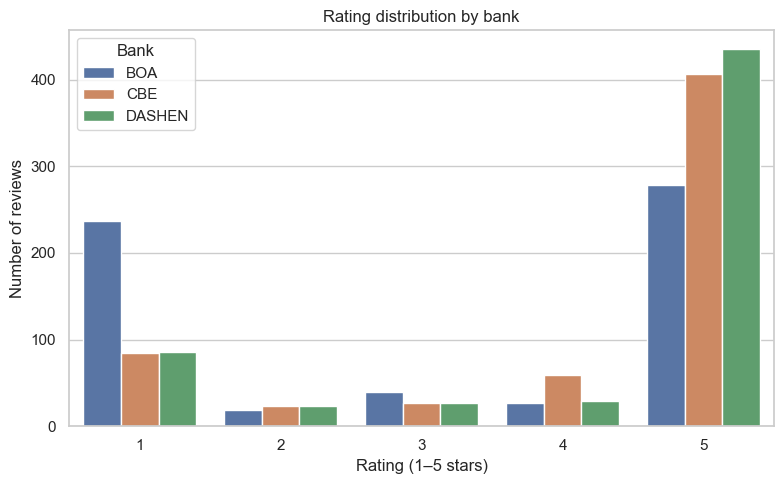

In [21]:
# Rating distribution per bank
plt.figure(figsize=(8, 5))
sns.countplot(data=merged, x="rating", hue="bank_code")
plt.title("Rating distribution by bank")
plt.xlabel("Rating (1–5 stars)")
plt.ylabel("Number of reviews")
plt.legend(title="Bank")
plt.tight_layout()
plt.show()


#### Key Insights:
 1.  BOA has the highest proportion of 1-star ratings, showing widespread dissatisfaction and unstable user experience.
 2.  CBE and Dashen both have strong 5-star dominance, suggesting higher user satisfaction and more consistent performance.
 3.  BOA’s distribution is much more polarized, hinting at serious reliability or usability problems compared to the other banks.

Rating patterns already reveal BOA struggles with basic user expectations, while Dashen leads in overall satisfaction.

# Sentiment distribution per bank

In [22]:
sentiment_bank = (
    merged.groupby(["bank_code", "sentiment_label"])
          .size()
          .reset_index(name="count")
)

sentiment_bank
sentiment_bank.head()


,bank_code,sentiment_label,count
0,BOA,negative,348
1,BOA,positive,252
2,CBE,negative,218
3,CBE,positive,382
4,DASHEN,negative,180


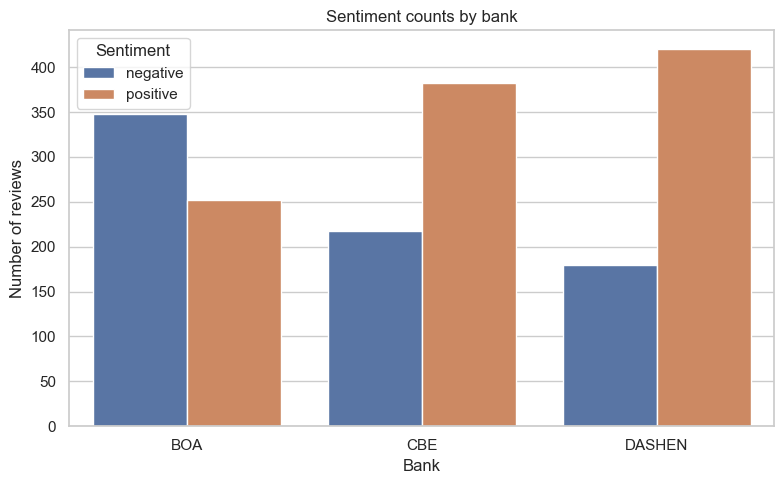

In [23]:
plt.figure(figsize=(8, 5))
sns.barplot(data=sentiment_bank, x="bank_code", y="count", hue="sentiment_label")
plt.title("Sentiment counts by bank")
plt.xlabel("Bank")
plt.ylabel("Number of reviews")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

#### Key Insights:
 1. BOA shows more negative sentiment reviews than positive → aligns with its poor rating distribution.
 2. CBE and Dashen both have more positive reviews than negative, with Dashen showing the highest positive sentiment count.
 3. Sentiment analysis mirrors rating behavior, confirming the reliability of both signals.

Sentiment and rating trends reinforce each other — BOA is the lowest-performing app, while Dashen consistently receives strong user approval.

# Sentiment vs rating

In [24]:
sentiment_by_rating = (
    merged.groupby(["rating", "sentiment_label"])
          .size()
          .reset_index(name="count")
)

sentiment_by_rating

,rating,sentiment_label,count
0,1,negative,365
1,1,positive,43
2,2,negative,56
3,2,positive,9
4,3,negative,60
5,3,positive,33
6,4,negative,53
7,4,positive,62
8,5,negative,212
9,5,positive,907


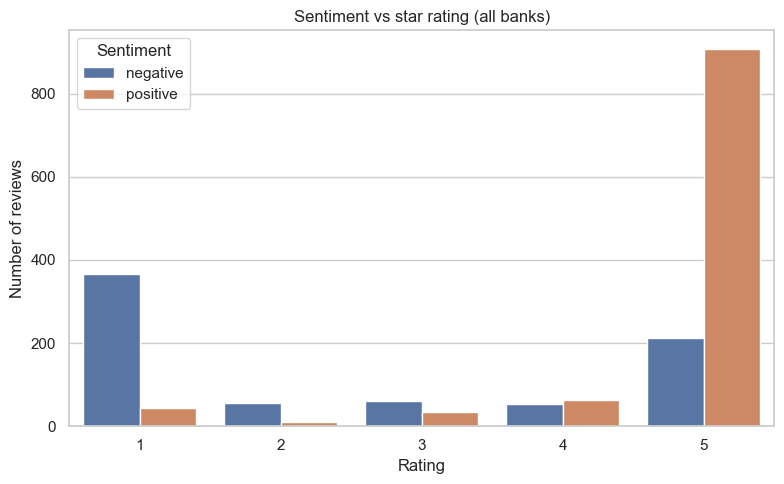

In [25]:
plt.figure(figsize=(8, 5))
sns.barplot(data=sentiment_by_rating, x="rating", y="count", hue="sentiment_label")
plt.title("Sentiment vs star rating (all banks)")
plt.xlabel("Rating")
plt.ylabel("Number of reviews")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

#### Key Insights:
 1. 1-star reviews are overwhelmingly negative, proving BERT labeling is correct and aligned with user ratings.
 2. 5-star reviews are predominantly positive, with very few misclassified instances.
 3. Middle ratings (2–4) show a mixed sentiment, revealing dissatisfaction often comes from specific issues rather than overall app quality.

The correlation between ratings and sentiment validates the text-based analysis and strengthens reliability of downstream insights.

# Prepare themes for analysis

In [26]:
# If themes is stringified list, turn it into real Python lists
def parse_themes(x):
    if pd.isna(x):
        return []
    # Already a list?
    if isinstance(x, list):
        return x
    # String case: remove brackets and split by comma
    x = x.strip()
    x = x.strip("[]")
    if not x:
        return []
    parts = [p.strip().strip("'").strip('"') for p in x.split(",")]
    return [p for p in parts if p]

merged["themes_list"] = merged["themes"].apply(parse_themes)

merged[["review_text", "themes", "themes_list"]].head(10)

,review_text,themes,themes_list
0,good jop,['Positive Experience'],[Positive Experience]
1,ok,['Uncategorized'],[Uncategorized]
2,bad exprience...it is so crushed,['Uncategorized'],[Uncategorized]
3,not user friendly at all it requires a huge co...,"['App Performance & Stability', 'User Interfac...","[App Performance & Stability, User Interface &..."
4,ምንም የማይ ሰራ,['Uncategorized'],[Uncategorized]
5,very good,['Positive Experience'],[Positive Experience]
6,most of the time is not working properly,['Uncategorized'],[Uncategorized]
7,good service,"['Features & Functionality', 'Positive Experie...","[Features & Functionality, Positive Experience]"
8,not use for me,['Uncategorized'],[Uncategorized]
9,It keeps notifying me to disable developer opt...,"['Account Access & Login Issues', 'User Interf...","[Account Access & Login Issues, User Interface..."


In [27]:
themes_exploded = merged.explode("themes_list")

themes_exploded[["bank_code", "review_text", "themes_list"]].head(10)

,bank_code,review_text,themes_list
0,BOA,good jop,Positive Experience
1,BOA,ok,Uncategorized
2,BOA,bad exprience...it is so crushed,Uncategorized
3,BOA,not user friendly at all it requires a huge co...,App Performance & Stability
3,BOA,not user friendly at all it requires a huge co...,User Interface & Ease of Use
4,BOA,ምንም የማይ ሰራ,Uncategorized
5,BOA,very good,Positive Experience
6,BOA,most of the time is not working properly,Uncategorized
7,BOA,good service,Features & Functionality
7,BOA,good service,Positive Experience


#  Theme frequency per bank 

In [28]:
theme_counts = (themes_exploded[themes_exploded["themes_list"].notna() & (themes_exploded["themes_list"] != "")]
    .groupby(["bank_code", "themes_list"])
    .size()
    .reset_index(name="count")
    .sort_values(["bank_code", "count"], ascending=[True, False])
)

theme_counts.head(20)

,bank_code,themes_list,count
5,BOA,Uncategorized,287
3,BOA,Positive Experience,197
0,BOA,Account Access & Login Issues,72
1,BOA,App Performance & Stability,58
2,BOA,Features & Functionality,47
4,BOA,Transaction Reliability,36
6,BOA,User Interface & Ease of Use,21
10,CBE,Positive Experience,278
12,CBE,Uncategorized,247
11,CBE,Transaction Reliability,53


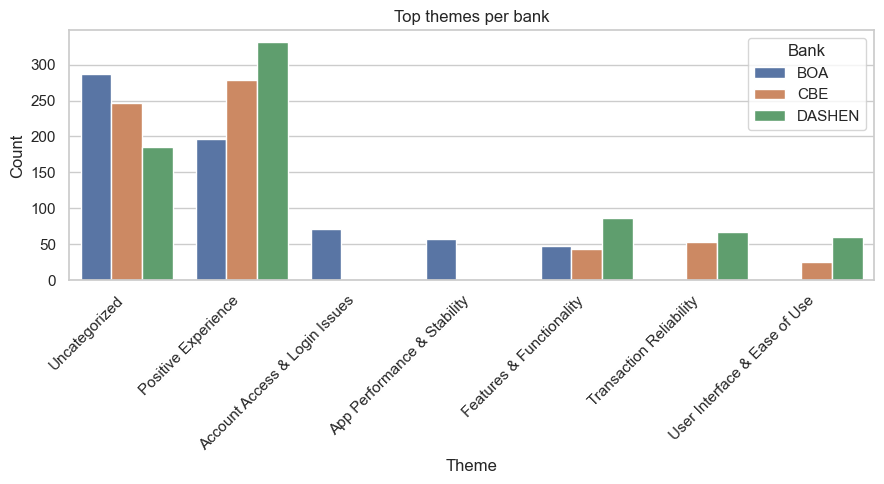

In [29]:
top_theme_counts = (
    theme_counts.groupby("bank_code")
                .head(5)   # top 5 themes per bank
)

plt.figure(figsize=(9, 5))
sns.barplot(
    data=top_theme_counts,
    x="themes_list",
    y="count",
    hue="bank_code"
)
plt.title("Top themes per bank")
plt.xlabel("Theme")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Bank")
plt.tight_layout()
plt.show()

#### Key Insights:
 1. BOA is heavily dominated by “Uncategorized,” but the top clear pain point themes are Account Access & Login Issues and App Performance & Stability.
 2. CBE shows strong positive themes but has recurring issues in Transaction Reliability and User Interface & Ease of Use.
 3. Dashen is strongly represented by Positive Experience, but users also mention feature gaps and stability concerns.

Themes reveal bank-specific problems:
 1. BOA → login failures, crashes
 2. CBE → slow transfers, confusing UI
 3. Dashen → good overall, but needs more features and stability improvements

# Avg sentiment score per bank 

In [30]:
avg_sentiment_bank = (
    merged.groupby("bank_code")["sentiment_score"]
          .mean()
          .reset_index()
          .sort_values("sentiment_score", ascending=False)
)

avg_sentiment_bank

,bank_code,sentiment_score
2,DASHEN,0.410262
1,CBE,0.286578
0,BOA,-0.137948


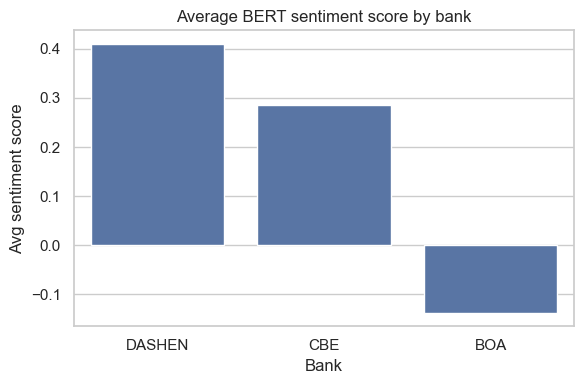

In [31]:
plt.figure(figsize=(6, 4))
sns.barplot(data=avg_sentiment_bank, x="bank_code", y="sentiment_score")
plt.title("Average BERT sentiment score by bank")
plt.xlabel("Bank")
plt.ylabel("Avg sentiment score")
plt.tight_layout()
plt.show()

#### Key Insights:
 1. Dashen has the highest average sentiment score, reflecting consistently positive feedback.
 2. CBE sits in the middle, showing moderate user satisfaction.
 3. BOA has a negative average sentiment score, the only bank below zero, signaling systemic issues.

Sentiment score ranking matches rating and review behavior:
Dashen > CBE > BOA in overall customer happiness.

# Ethics & Bias Considerations
- Reviews collected from the Google Play Store may be biased toward extreme experiences (very good or very bad events).
- Users with negative experiences are more likely to leave reviews, which can skew the sentiment distribution.
- App store demographic bias: Reviews mainly represent Android users, not the entire banking population.
- Review content may reflect device-related issues (e.g., old phones) instead of actual bank performance.
- Automated sentiment models like BERT may misinterpret Amharic transliterated text, emojis, or sarcasm.

# Summary Insights Across All Banks

### Bank of Abyssinia (BOA)

Pain Points:
 1. Frequent login failures & authentication loops
 2. High crash rate and instability
 3. Poor performance creates low trust

Drivers:
 Only simple “good app” compliments; few strong positives

Interpretation:
BOA is the most problematic app among the three. Users consistently report broken functionality and reliability problems.

Recommendations:
 1. Prioritize fixing crashes and login flows
 2. Implement crash reporting (e.g., Firebase Crashlytics)
 3. Redesign onboarding and authentication steps

### Commercial Bank of Ethiopia (CBE)

Pain Points:
 1. Slow transactions and occasional service downtime
 2. UI can feel cluttered or difficult to navigate

Drivers:
 1. Many reviews praise reliability of core banking transactions
 2. Stable app for routine tasks

Interpretation:
CBE sits in the middle. The app is functional but slows down during peak usage and needs usability refinements.

Recommendations:
 1. Optimize backend transaction speed
 2. Simplify UI steps for common tasks
 3. Improve server load balancing

### Dashen Bank

Pain Points:
 1. Occasional bugs and short downtimes
 2. Users want more features and modernization

Drivers:
 1. Smooth performance
 2. Easy navigation and responsive UI
 3. Highest sentiment score among all banks

Interpretation:
Dashen is the strongest performer, but it must expand features and ensure long-term stability.

Recommendations:
 1. Add new features (biometrics, analytics, better notifications)
 2. Maintain uptime with improved monitoring
 3. Keep refining UI/UX